## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

# Set up the paths
cleaned_data_path = os.path.join('..', 'data', 'cleaned')
processed_data_path = os.path.join('..', 'data', 'processed')

report_path = os.path.join('..', 'reports')
figure_path = os.path.join('..', 'reports', 'figures')
model_path = os.path.join('..', 'models')

model_names = ['RandomForestClassifier', 'HistGradientBoostingClassifier']
model_name = model_names[0]


## 1 - Load and prepare the training dataset

In [2]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

import pyLDAvis
import pyLDAvis.lda_model
from pyLDAvis import PreparedData

pyLDAvis.enable_notebook()

In [3]:
# Load the training dataset
procd_train_path = os.path.join(processed_data_path, 'procd_train.parquet')

if os.path.exists(procd_train_path):
    procd_train = pd.read_parquet(procd_train_path)
else:
    # Load the training dataset
    train_df = pd.read_parquet(os.path.join(cleaned_data_path, 'train.parquet'))

    procd_train = build_features.prepare_data(train_df, 'train', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_train.to_parquet(procd_train_path)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [4]:
# Load the validation dataset
procd_val_path = os.path.join(processed_data_path, 'procd_val.parquet')

if os.path.exists(procd_val_path):
    procd_val = pd.read_parquet(procd_val_path)
else:
    # Load the validation dataset
    val_df = pd.read_parquet(os.path.join(cleaned_data_path, 'val.parquet'))

    procd_val = build_features.prepare_data(val_df, 'val', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_val.to_parquet(procd_val_path)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [5]:
# Load the test dataset
procd_test_path = os.path.join(processed_data_path, 'procd_test.parquet')

if os.path.exists(procd_test_path):
    procd_test = pd.read_parquet(procd_test_path)
else:
    # Load the test dataset
    test_df = pd.read_parquet(os.path.join(cleaned_data_path, 'test.parquet'))

    procd_test = build_features.prepare_data(test_df, 'test', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_test.to_parquet(procd_test_path)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [6]:
# Concatenate the training, validation and test datasets
procd_data = pd.concat([procd_train, procd_val, procd_test])

# Define the X_train and y_train
X_train = procd_data.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_train = procd_data['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (131470, 58)
y Shape: (131470,)


## 2 - Load and prepare the final evaluation dataset

### 2.1 - Load the final evaluation dataset

In [7]:
# Load the final evaluation dataset
procd_final_eval_path = os.path.join(processed_data_path, 'procd_final_eval.parquet')

if os.path.exists(procd_final_eval_path):
    procd_final_eval = pd.read_parquet(procd_final_eval_path)
else:
    # Load the final evaluation dataset
    final_eval_df = pd.read_parquet(os.path.join(cleaned_data_path, 'final_evaluation.parquet'))

    procd_final_eval = build_features.prepare_data(final_eval_df, 'final_eval', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_final_eval.to_parquet(procd_final_eval_path)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [8]:
# Define the X_eval and y_eval
X_eval = procd_final_eval.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_eval.shape}')

y_eval = procd_final_eval['DIAG1_CAT'].copy()
print(f'y Shape: {y_eval.shape}')

X Shape: (25352, 58)
y Shape: (25352,)


### 2.2 - Check the topic and the label distributions

In [9]:
def prepared_data_from_dict(vis_data):
    # Code adapted from https://github.com/bmabey/pyLDAvis/issues/134
    topic_coordinates = pd.DataFrame.from_dict(vis_data['mdsDat'])
    topic_info = pd.DataFrame.from_dict(vis_data['tinfo'])
    token_table = pd.DataFrame.from_dict(vis_data['token.table'])
    R = vis_data['R']
    lambda_step = vis_data['lambda.step']
    plot_opts = vis_data['plot.opts']
    client_topic_order = vis_data['topic.order']

    return PreparedData(topic_coordinates, topic_info,
                        token_table, R, lambda_step, plot_opts, client_topic_order)


# Load and display the pyLDAvis from saved json file
with open(os.path.join(report_path, 'final_eval_lda_vis.json'), 'r') as f:
    lda_vis = json.load(f)

# Display the pyLDAvis from saved json file
prepared_data = prepared_data_from_dict(lda_vis)
pyLDAvis.display(prepared_data)

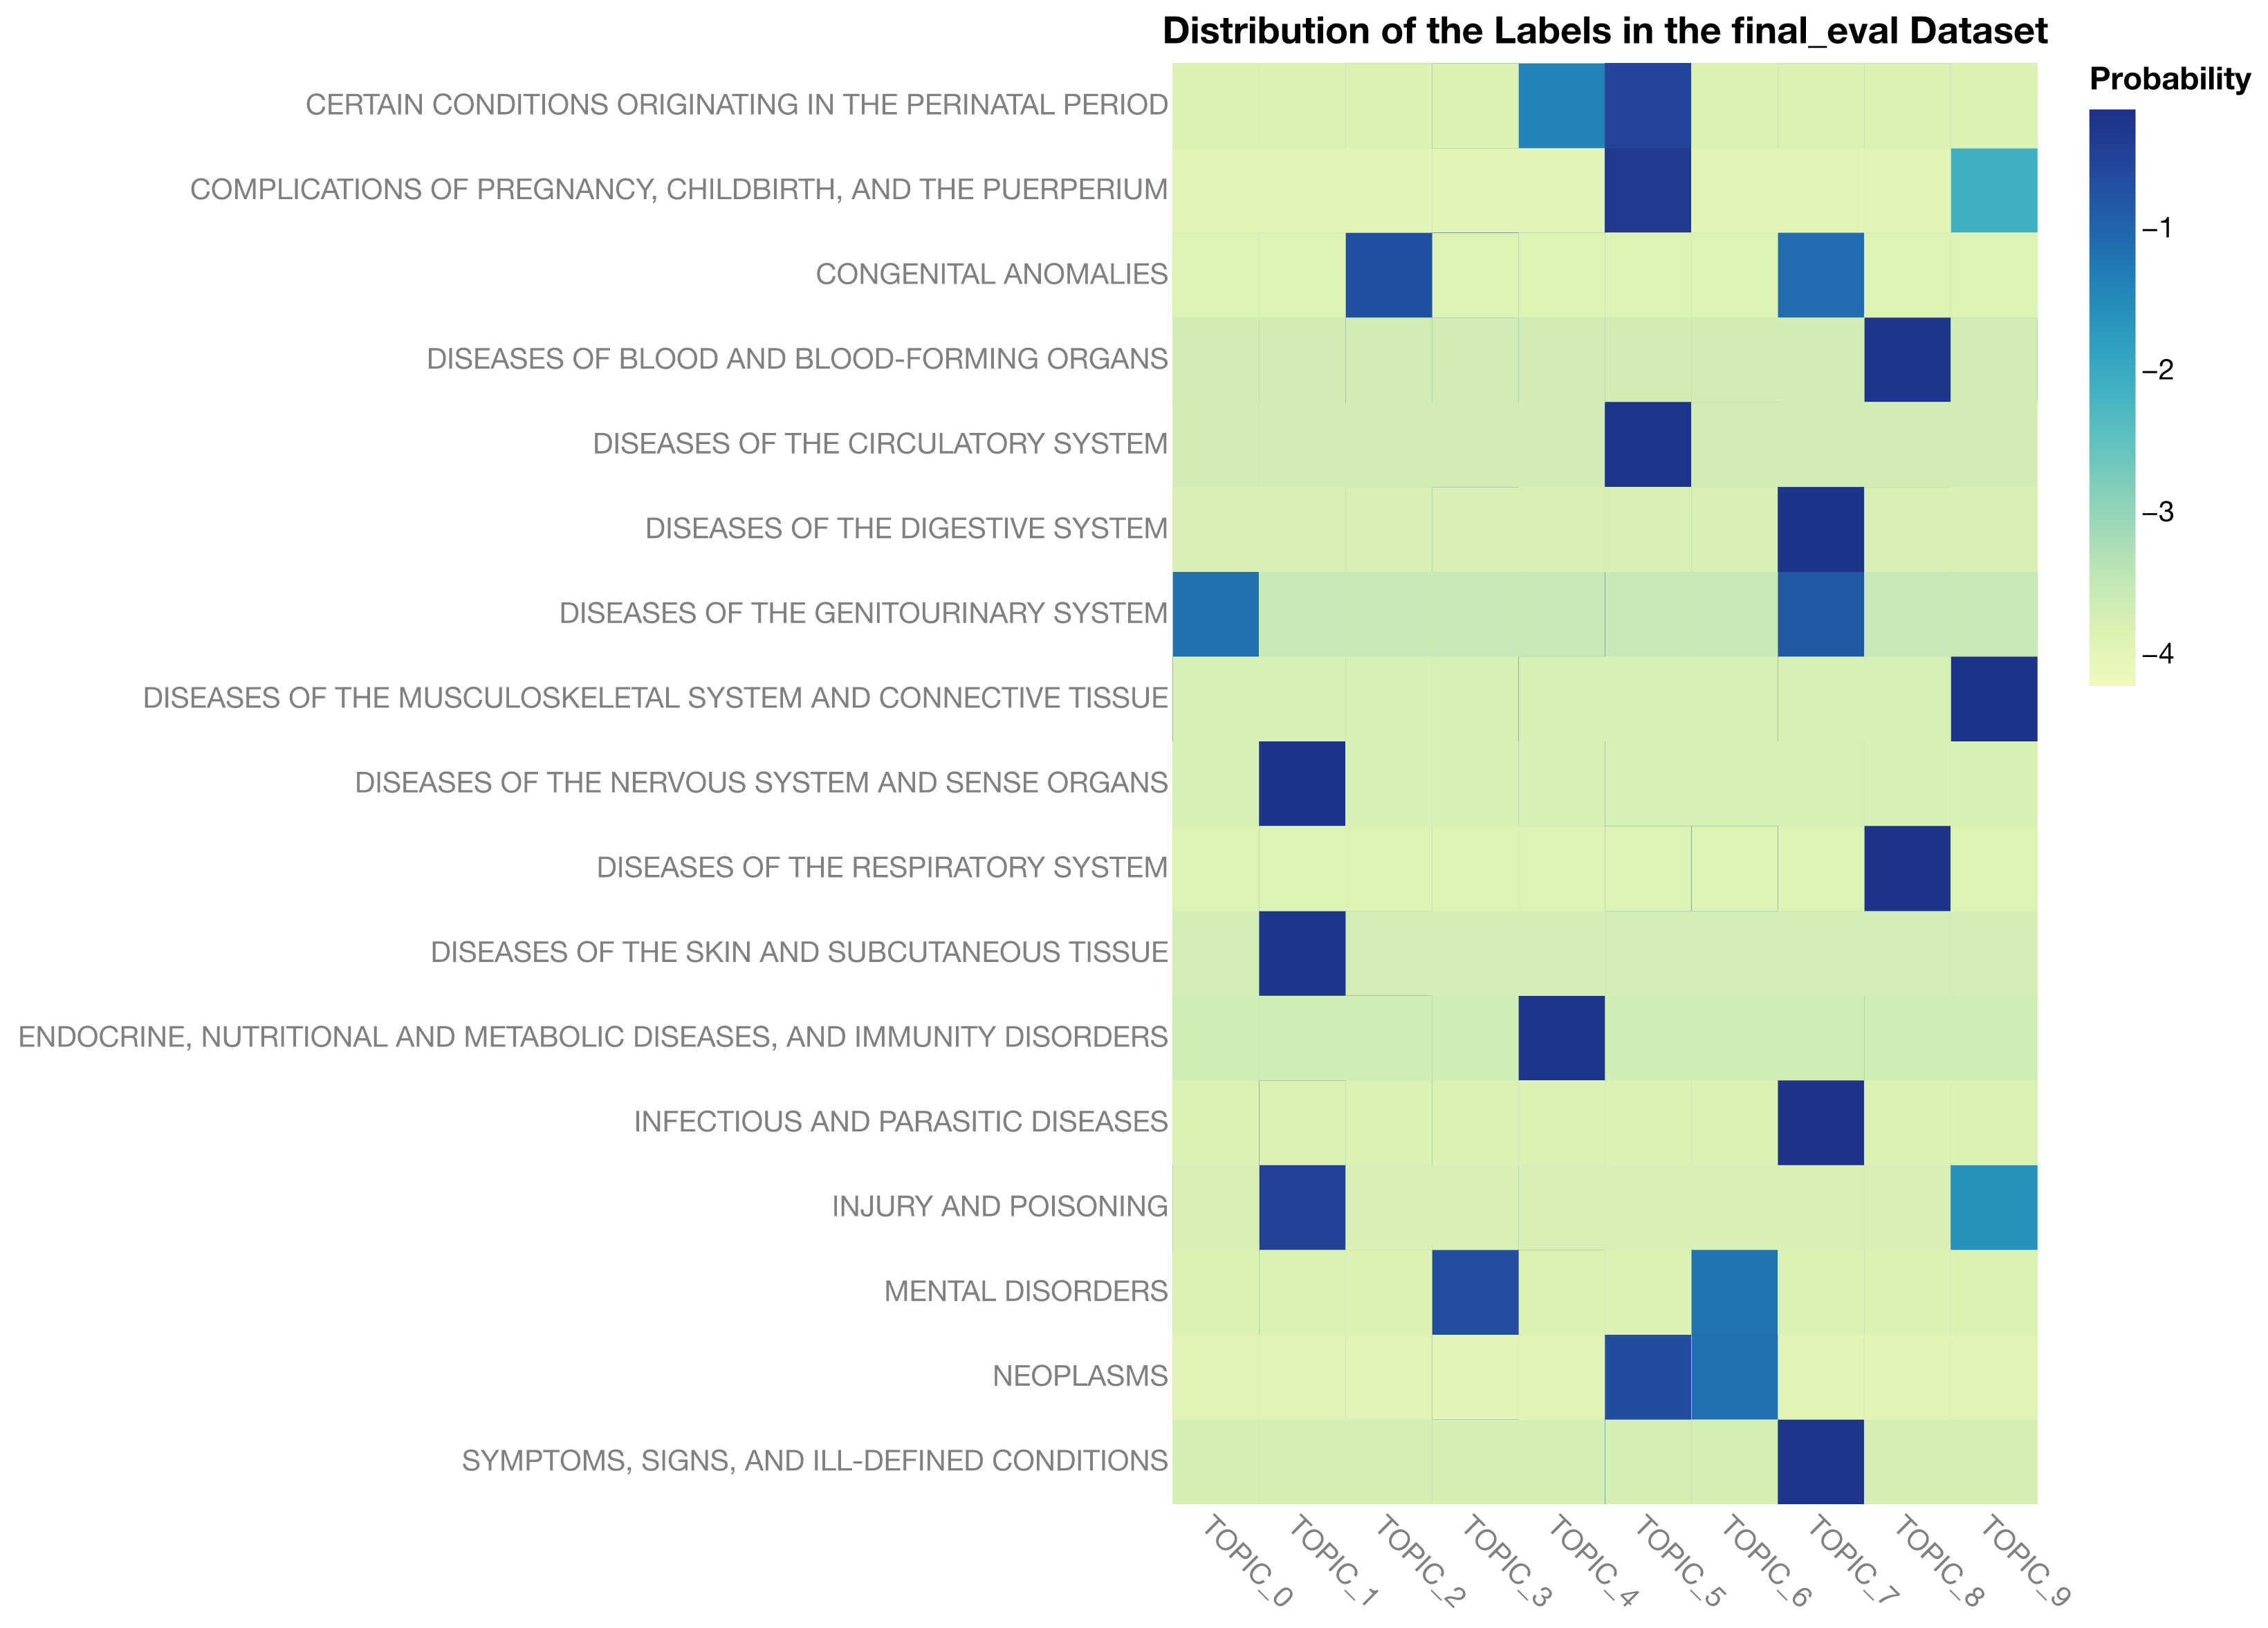

In [10]:
# Load and display the heat map of topic distributions among the labels
from IPython.display import Image
Image(filename=os.path.join(figure_path, 'final_eval_topic_distribution_heatmap.png'))

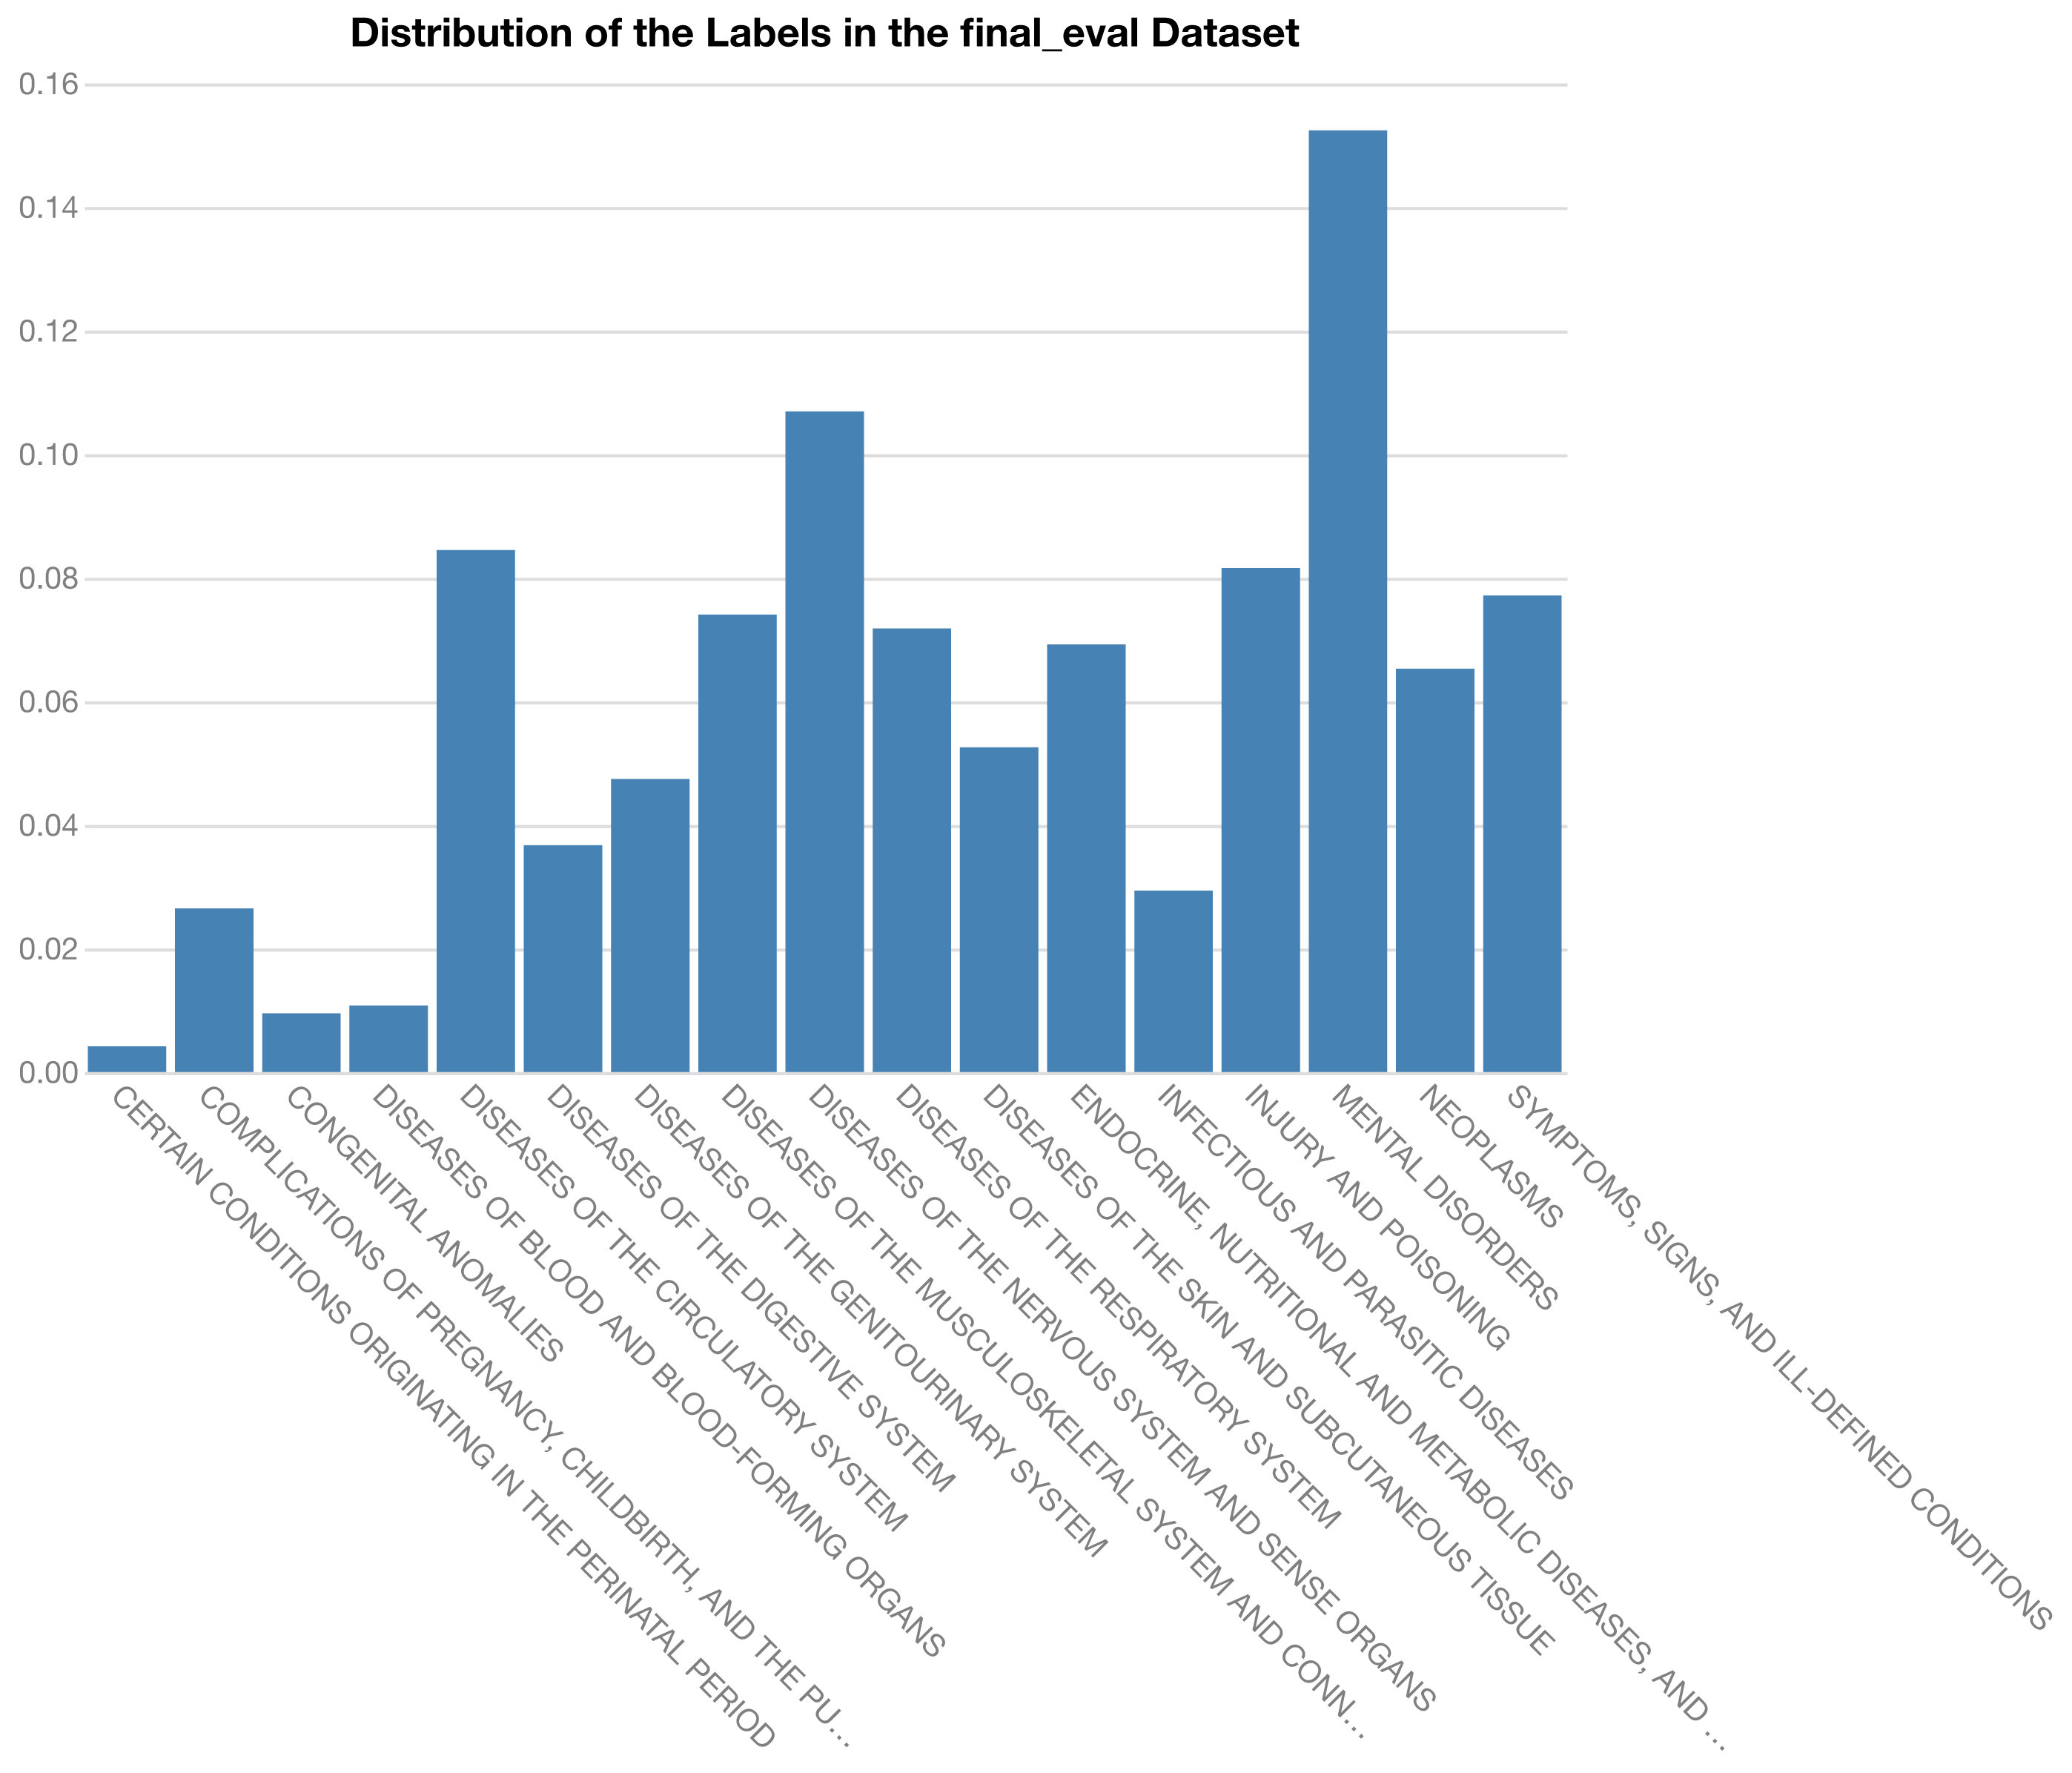

In [11]:
# Load and display the distribution and percentage of the labels
from IPython.display import display
display(Image(filename=os.path.join(figure_path, 'final_eval_label_distribution.png')))

## 3 - Evaluate the best model with the final evaluation dataset

In [12]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, label_ranking_average_precision_score, classification_report

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

class OptionalPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
    
    def fit(self, X, y=None):
        if self.n_components is not None:
            self.pca.fit(X)
        return self
    
    def transform(self, X):
        if self.n_components is not None:
            return self.pca.transform(X)
        return X

### 3.1 - Reload the saved model

In [13]:
# Load the saved model
halving_search = joblib.load(os.path.join(model_path, f'{model_name}_halving_search_model.joblib'))

/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 

### 3.2 - Prediction and Metrics

In [14]:
y_pred = halving_search.predict(X_eval)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
le = LabelEncoder()
y_eval_encoded = le.fit_transform(y_eval)
y_pred_encoded = le.transform(y_pred)

n_classes = len(le.classes_)
y_eval_binarized = label_binarize(y_eval_encoded, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_encoded, classes=range(n_classes))

lrap = label_ranking_average_precision_score(y_eval_binarized, y_pred_binarized)
print(f'Label Ranking Average Precision Score: {lrap}')

Label Ranking Average Precision Score: 0.6630222931711306


In [16]:
accuracy = accuracy_score(y_eval, y_pred)
print(f'Prediction Accuracy: {accuracy}')

f1 = f1_score(y_eval, y_pred, average='weighted')
print(f'Weighted Prediction F1 Score: {f1}')

print(classification_report(y_eval[y_eval.notna()], y_pred[y_eval.notna()]))

Prediction Accuracy: 0.6419611864941622
Weighted Prediction F1 Score: 0.6304181622503433
                                                                       precision    recall  f1-score   support

               CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.34      0.66      0.45       106
           COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.71      0.78      0.74       672
                                                 CONGENITAL ANOMALIES       0.29      0.39      0.33       241
                           DISEASES OF BLOOD AND BLOOD-FORMING ORGANS       0.48      0.33      0.39       273
                                   DISEASES OF THE CIRCULATORY SYSTEM       0.55      0.56      0.56      2142
                                     DISEASES OF THE DIGESTIVE SYSTEM       0.46      0.57      0.51       931
                                 DISEASES OF THE GENITOURINARY SYSTEM       0.53      0.63      0.58      1203
         DISEASES OF T

### 3.3 - Confusion matrix

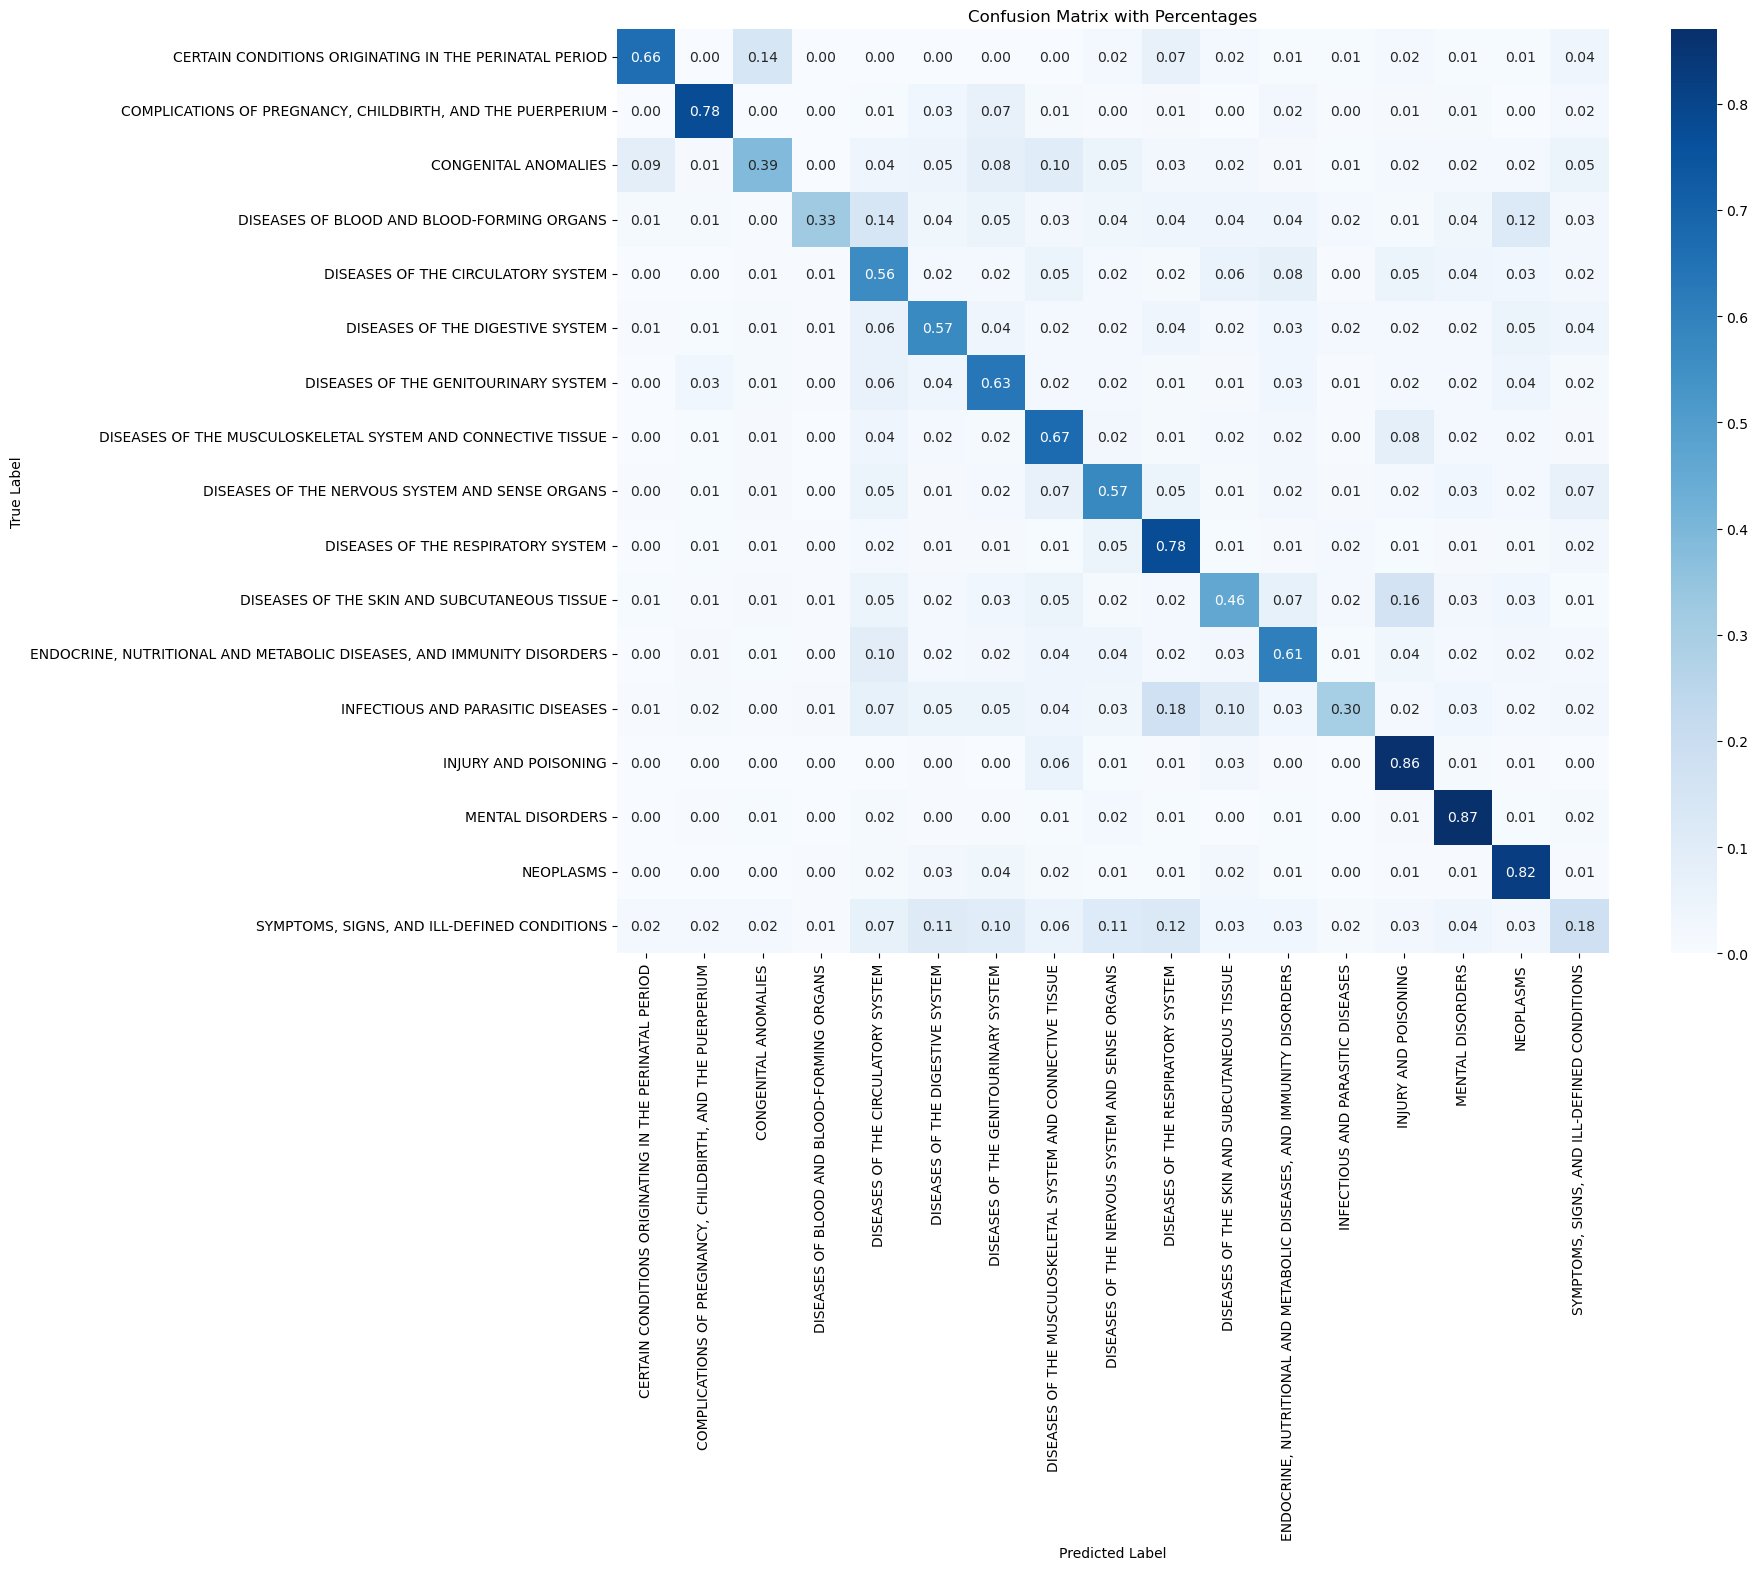

In [17]:
# Plot the confusion matrix with percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_eval, y_pred)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=halving_search.classes_, yticklabels=halving_search.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

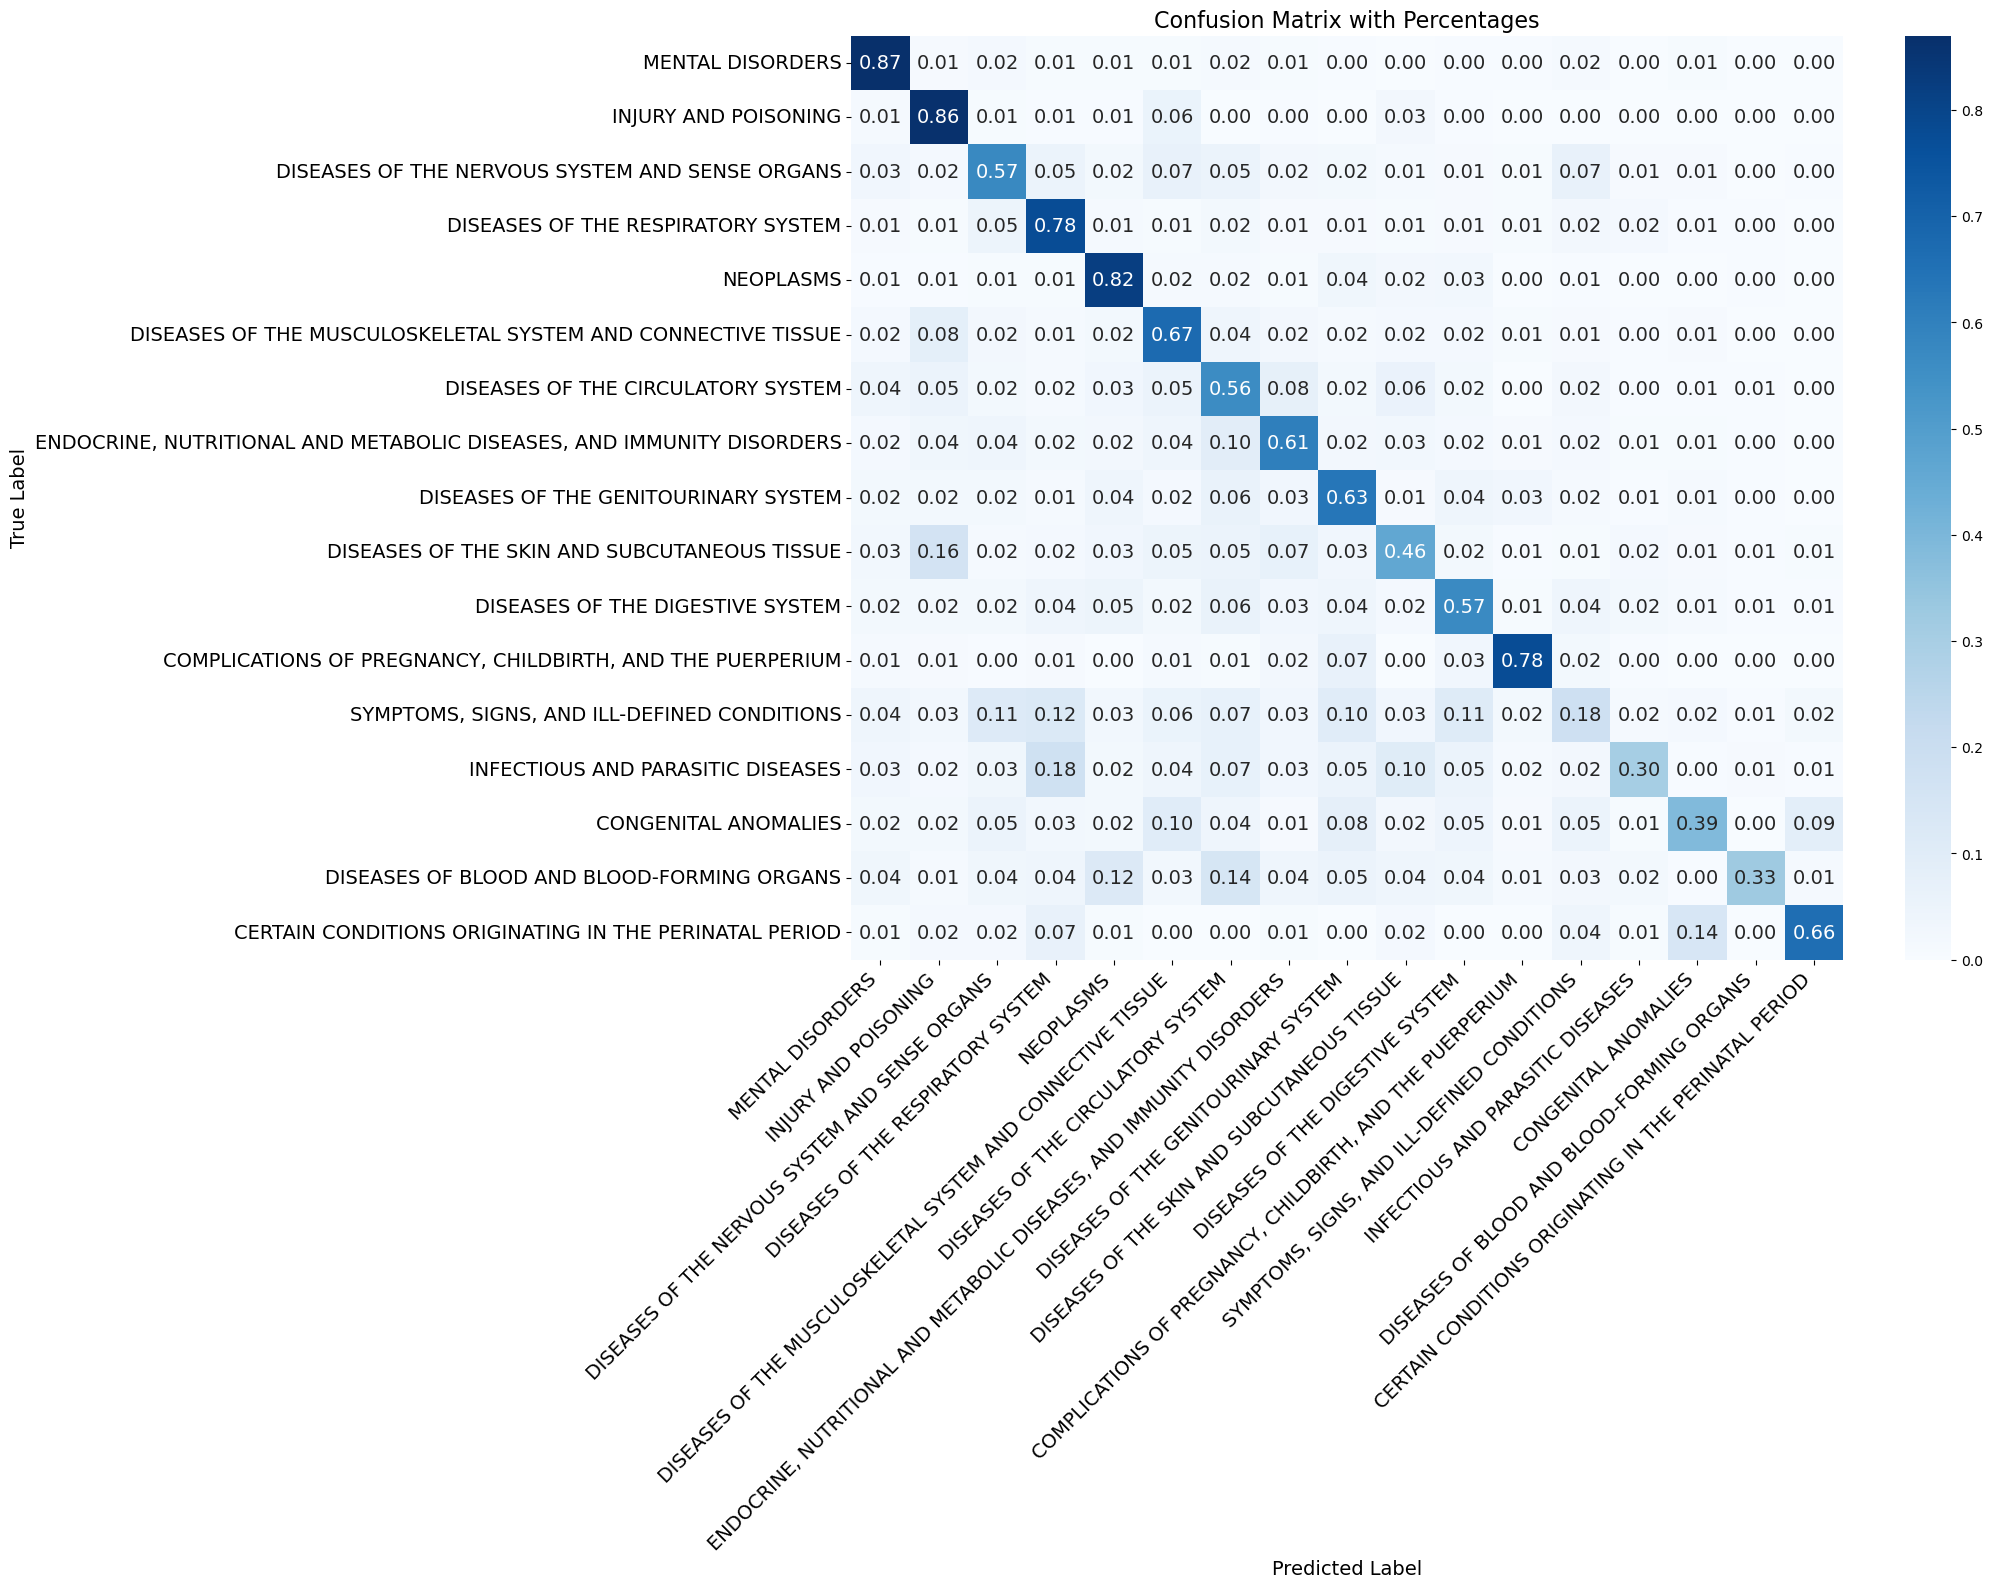

In [18]:
cm = confusion_matrix(y_eval, y_pred)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

order = np.argsort(np.diag(cm))[::-1]
cm_sorted = cm[order][:, order]
classes_sorted = halving_search.classes_[order]
cm_percent_sorted = cm_sorted / cm_sorted.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(
    cm_percent_sorted, annot=True, fmt=".2f", cmap='Blues',
    xticklabels=classes_sorted, yticklabels=classes_sorted, ax=ax,
    annot_kws={"size": 14}
)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix with Percentages', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

## 4 - Retrain the final model with training, validation, test and final evaluation datasets concatenated

### 4.1 - Concatenate training, validation, test and final evaluation datasets

In [19]:
# Concatenate training, validation, test and final evaluation datasets
procd_data = pd.concat([procd_train, procd_val, procd_test, procd_final_eval])

# Define the X_train and y_train
X_train = procd_data.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_train = procd_data['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (156822, 58)
y Shape: (156822,)


### 4.2 - Define the feature sets

In [20]:
# Define the feature sets
# With original quantitative data and RFV codes + RFV Modules + Topic Features
binary_features = [
    'SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS'
]
quantitative_features = ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']
topic_features = [col for col in X_train.columns if col.startswith('TOPIC')]

clf_features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[clf_features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[clf_features].shape}')
print(f'Features to be fit: \n{X_train[clf_features].columns}')

Missing Values in X_train: 
PASTVIS    31036.0
HTIN       83289.0
WTLB       53188.0
BMI        91689.0
TEMPF      82406.0
BPSYS      61276.0
BPDIAS     61494.0
dtype: float64

Shape of X_train: (156822, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')


### 4.3 - Refit the final model

In [21]:
# Refit the final model if the final_model does not exist
if not os.path.exists(os.path.join(model_path, f'{model_name}_final_model.joblib')):
    # Refit the final model
    best_estimator = halving_search.best_estimator_
    best_estimator.fit(X_train[clf_features], y_train)

    # Save the final model
    joblib.dump(best_estimator, os.path.join(model_path, f'{model_name}_final_model.joblib'))

## 5 - Visualize the feature importances of the top 20 features

### 5.1 - Load the final model

In [22]:
best_estimator = joblib.load(os.path.join(model_path, f'{model_name}_final_model.joblib'))

##### 5.2.2.1 - Visualize the feature importances of the top 20 features

In [23]:
if best_estimator.named_steps['classifier'].__class__.__name__ == 'RandomForestClassifier':
    importances = best_estimator.named_steps['classifier'].feature_importances_
    feature_names = best_estimator[:-2].get_feature_names_out(clf_features)

    indices = np.argsort(importances)[::-1]
    feature_names = [feature_names[i] for i in indices]

    # Plot the feature importances
    top_n = 20

    feature_importance_chart = build_features.chart(
        df=pd.DataFrame({'Feature': feature_names, 'Importance': importances[indices]}).head(top_n),
        x=alt.X('Feature:N', sort='-y'),
        y='Importance:Q',
        title=f'Top {top_n} Feature Importances',
    ).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None)

feature_importance_chart

alt.Chart(...)